# **Simulation Hedy 2025**

Team: TU Wien Space Team \
Project: Lamarr \
Rocket: Hedy \


## Installs

In this section all needed libraries are installed and the needed classes imported

In [45]:
pip install rocketpy

Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install CoolProp

Note: you may need to restart the kernel to use updated packages.


In [47]:
from rocketpy import Environment, Rocket, Flight, Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank, TrapezoidalFins, FreeFormFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute, CompareFlights
import rocketpy as rpy
from math import exp
from math import pi
import datetime
import json
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
from rocketpy.mathutils import Function

## Configuration (new)

Several config dictionaries define different flight parameters -> the different flight objects are stored in a list to later compare them with RocketPy's comparison tools

In [49]:
# the file paths of all dictionaries to be simulated
config_dict_list = [
    "config_dict.json",
    "config_dict_2.json"
]

flight_list = []

for config in config_dict_list:
    # load the config json into a dictionary
    with open(config, "rt") as f:
        config_dict = json.loads(f.read())

    # flags initialisation
    # select whether preset mass from config sheet is used...
    use_preset_mass = config_dict["Flags"]["flag"]["use_preset_mass"]["Value"]
    # ...or highest geometrically possible mass is used
    # if both these flags are set to False, the mass is calculated through (massflow * burntime * (1 + overfill percentage))
    use_max_n2_mass = config_dict["Flags"]["flag"]["use_max_nitrogen_mass"]["Value"]
    use_max_mass = config_dict["Flags"]["flag"]["use_max_mass"]["Value"] # for fuel and lox
    # select whether thrust is a constant integer or a .csv file is provided
    use_static_thrust = config_dict["Flags"]["flag"]["use_static_thrust"]["Value"]
    # select whether the simulation adds ice weight to total rocket weight
    account_for_ice = config_dict["Flags"]["flag"]["account_for_ice"]["Value"]
    # select whether freeform fins or trapezoidal fins are used in the simulation
    use_freeform_fins = config_dict["Flags"]["flag"]["use_freeform_fins"]["Value"]

    # check for valid flag selection (max and preset cannot be used simultaneously)
    if use_preset_mass and use_max_mass:
        print("Flag selection error")

    # Environment config // if environment should be with forecast, this code section must be adapted
    env = Environment()
    
    # convert from list to datetime -> ugly but it works
    date = datetime.datetime(
        int(config_dict["Environment"]["env"]["date"]["Value"][0]),
        int(config_dict["Environment"]["env"]["date"]["Value"][1]),
        int(config_dict["Environment"]["env"]["date"]["Value"][2]),
        int(config_dict["Environment"]["env"]["date"]["Value"][3]),
        int(config_dict["Environment"]["env"]["date"]["Value"][4]),
        int(config_dict["Environment"]["env"]["date"]["Value"][5])
        )
    
    env.set_location(
        latitude = config_dict["Environment"]["env"]["latitude"]["Value"],
        longitude = config_dict["Environment"]["env"]["longitude"]["Value"]
    )
    env.set_elevation("Open-Elevation")
    env.set_atmospheric_model(type = "standard_atmosphere")
    env.set_date(
        date,
        timezone = config_dict["Environment"]["env"]["timezone"]["Value"]
    )
    # end of environment section
    # Tanks config

    # preset initialisation
    t_burn = config_dict["Motor"]["presets"]["burn_time"]["Value"]
    t_holddown = config_dict["Motor"]["presets"]["holddown_time"]["Value"]

    if t_holddown > t_burn:
        print("Holddown time too long -> Time error")

    overfill_percentage = config_dict["Motor"]["presets"]["overfill_percentage"]["Value"]

    if use_static_thrust:
        thrust = lambda t: config_dict["Motor"]["presets"]["thrust"]["Value"]
    else:
        thrust = config_dict["Motor"]["presets"]["thrust"]["Value"] # should contain a file path string -> needs to be tested
    
    # geometrical initialisation
    length_n2_tank = config_dict["Motor"]["nitrogen_tank"]["length"]["Value"]
    length_fuel_tank = config_dict["Motor"]["ethanol_tank"]["length"]["Value"]
    length_lox_tank = config_dict["Motor"]["lox_tank"]["length"]["Value"]

    outer_diameter_n2_tank = config_dict["Motor"]["nitrogen_tank"]["outer_diameter"]["Value"]
    outer_diameter_fuel_tank = config_dict["Motor"]["ethanol_tank"]["outer_diameter"]["Value"]
    outer_diameter_lox_tank = config_dict["Motor"]["lox_tank"]["outer_diameter"]["Value"]

    thickness_n2_tank = config_dict["Motor"]["nitrogen_tank"]["thickness"]["Value"]
    thickness_fuel_tank = config_dict["Motor"]["ethanol_tank"]["thickness"]["Value"]
    thickness_lox_tank = config_dict["Motor"]["lox_tank"]["thickness"]["Value"]

    inner_diameter_n2_tank = outer_diameter_n2_tank - (2 * thickness_n2_tank)
    inner_diameter_fuel_tank = outer_diameter_fuel_tank - (2 * thickness_fuel_tank)
    inner_diameter_lox_tank = outer_diameter_lox_tank - (2 * thickness_lox_tank)

    n2_tank_shape = CylindricalTank(radius=(inner_diameter_n2_tank/2), height=length_n2_tank, spherical_caps=True)
    fuel_tank_shape = CylindricalTank(radius=(inner_diameter_fuel_tank/2), height=length_fuel_tank, spherical_caps=True)
    lox_tank_shape = CylindricalTank(radius=(inner_diameter_lox_tank/2), height=length_lox_tank, spherical_caps=True)

    nozzle_diameter = config_dict["Motor"]["nozzle"]["diameter"]["Value"]
    nozzle_position = config_dict["Motor"]["nozzle"]["position"]["Value"]

    # fluid dynamical initialisation
    massflow_n2 = config_dict["Motor"]["nitrogen_tank"]["massflow"]["Value"]
    massflow_fuel = config_dict["Motor"]["ethanol_tank"]["massflow"]["Value"]
    massflow_lox = config_dict["Motor"]["lox_tank"]["massflow"]["Value"]

    temperature_n2 = config_dict["Motor"]["presets"]["nitrogen_temperature"]["Value"]
    temperature_fuel = config_dict["Motor"]["presets"]["ethanol_temperature"]["Value"]
    temperature_lox = config_dict["Motor"]["presets"]["lox_temperature"]["Value"]

    pressure_n2 = config_dict["Motor"]["presets"]["nitrogen_pressure"]["Value"]
    pressure_fuel = config_dict["Motor"]["presets"]["ethanol_pressure"]["Value"]
    pressure_lox = config_dict["Motor"]["presets"]["lox_pressure"]["Value"]

    density_n2 = CP.PropsSI("D","T",temperature_n2,"P|gas",pressure_n2,"N2")
    density_fuel = CP.PropsSI("D", "T|liquid", temperature_fuel, "P", pressure_fuel, "ethanol")
    density_lox = CP.PropsSI("D", "T|liquid", temperature_lox, "P", pressure_lox, "oxygen")
    
    n2 = Fluid(name = "N2", density = density_n2)
    fuel = Fluid(name = "ethanol", density = density_fuel)
    lox = Fluid(name = "LOX", density = density_lox)

    # Mass flags processing
    # calculate mass that is passed on to RocketPy considering the selected flags
    if use_max_n2_mass:
        mass_n2 = n2_tank_shape.total_volume * density_n2
        # notify user if burn time is too long for available amount of n2 under given massflow
        if (mass_n2 / massflow_n2) < t_burn:
            print("Burntime too long or massflow too fast -> Nitrogen error")
    else:
        mass_n2 = massflow_n2 * t_burn * (1 + (overfill_percentage/100)) # if conversion from % is implemented in config generator -> remove /100
    
    if use_preset_mass:
        mass_fuel = config_dict["Motor"]["presets"]["ethanol_mass"]["Value"]
        mass_lox = config_dict["Motor"]["presets"]["lox_mass"]["Value"]
    elif use_max_mass:
        mass_fuel = fuel_tank_shape.total_volume * density_fuel
        mass_lox = lox_tank_shape.total_volume * density_fuel
        # if max values are used, burn time needs to be adjusted as this is now the variable
        if (mass_fuel / massflow_fuel) < (mass_lox / massflow_lox):
            t_burn = mass_fuel / massflow_fuel
        else:
            t_burn = mass_lox / massflow_lox
    else:
        mass_fuel = massflow_fuel * t_burn * (1 + (overfill_percentage/100))
        mass_lox = massflow_lox * t_burn * (1 + (overfill_percentage/100))

    # finally the burn time is updated to account for the holddown time; the mass which contributes to the flight is updated as well
    t_burn -= t_holddown
    mass_fuel -= massflow_fuel * t_holddown
    mass_lox -= massflow_lox * t_holddown

    # Mass flow rate tank model definitions
    n2_tank = MassFlowRateBasedTank(
        name="n2 tank",
        geometry=n2_tank_shape,
        flux_time=t_burn, # why is (mass_n2 / massflow_n2) used here in the original script?
        initial_liquid_mass=0,
        initial_gas_mass=mass_n2,
        liquid_mass_flow_rate_in=0,
        liquid_mass_flow_rate_out=0,
        gas_mass_flow_rate_in=0,
        gas_mass_flow_rate_out=lambda t: massflow_n2,
        liquid=Fluid(name="irrelevant", density=0.0001),
        gas=n2
    )
    
    fuel_tank = MassFlowRateBasedTank(
        name="fuel tank",
        geometry=fuel_tank_shape,
        flux_time=t_burn,
        initial_liquid_mass=mass_fuel,
        initial_gas_mass=0, # can be neglected
        liquid_mass_flow_rate_in=0,
        liquid_mass_flow_rate_out=lambda t: massflow_fuel,
        gas_mass_flow_rate_in=lambda t: massflow_n2,
        gas_mass_flow_rate_out=0,
        liquid=fuel,
        gas=n2
    )

    lox_tank = MassFlowRateBasedTank(
        name="lox tank",
        geometry=lox_tank_shape,
        flux_time=t_burn,
        initial_liquid_mass=mass_lox,
        initial_gas_mass = 0, # can be neglected
        liquid_mass_flow_rate_in=0,
        liquid_mass_flow_rate_out=lambda t: massflow_lox,
        gas_mass_flow_rate_in=lambda t: massflow_n2,
        gas_mass_flow_rate_out=0,
        liquid=lox,
        gas = n2
    )

    propulsion_system = LiquidMotor(
        dry_mass=0.0001,
        dry_inertia=(0,0,0),
        center_of_dry_mass_position=0,
        nozzle_radius=(nozzle_diameter/2),
        nozzle_position=nozzle_position,
        thrust_source=thrust,
        burn_time=t_burn,
        coordinate_system_orientation="nozzle_to_combustion_chamber"
    )

    propulsion_system.add_tank(tank=fuel_tank, position=config_dict["Motor"]["ethanol_tank"]["CG"]["Value"])
    propulsion_system.add_tank(tank=lox_tank, position=config_dict["Motor"]["lox_tank"]["CG"]["Value"])
    propulsion_system.add_tank(tank=n2_tank, position=config_dict["Motor"]["nitrogen_tank"]["CG_ethanol"]["Value"])
    propulsion_system.add_tank(tank=n2_tank, position=config_dict["Motor"]["nitrogen_tank"]["CG_lox"]["Value"])

    #propulsion_system.all_info()

    # Rocket initialisation
    rocket_length = config_dict["Rocket"]["geometry"]["length"]["Value"]
    rocket_diameter = config_dict["Rocket"]["geometry"]["diameter"]["Value"]
    rocket_thickness = config_dict["Rocket"]["geometry"]["thickness"]["Value"]

    tailcone_diameter = config_dict["Rocket"]["tailcone"]["diameter"]["Value"]
    tailcone_length = config_dict["Rocket"]["tailcone"]["length"]["Value"]
    tailcone_cylindrical_height = config_dict["Rocket"]["tailcone"]["cylindrical_height"]["Value"]

    nosecone_length = config_dict["Rocket"]["nosecone"]["length"]["Value"]
    nosecone_kind = config_dict["Rocket"]["nosecone"]["kind"]["Value"]

    upper_railbutton_position = config_dict["Rocket"]["railbuttons"]["upper"]["Value"]
    lower_railbutton_position = config_dict["Rocket"]["railbuttons"]["lower"]["Value"]

    rocket_mass = config_dict["Rocket"]["geometry"]["weight"]["Value"]
    
    if account_for_ice:
        rocket_mass += config_dict["Motor"]["presets"]["ice_mass"]["Value"]

    inertia_xy = config_dict["Rocket"]["geometry"]["inertia_xy"]["Value"]
    inertia_z = config_dict["Rocket"]["geometry"]["inertia_z"]["Value"]

    cg = config_dict["Rocket"]["geometry"]["CG"]["Value"]

    fin_amount = config_dict["Rocket"]["fins"]["amount"]["Value"]

    if use_freeform_fins:
        fin_shape_points_amount = int(config_dict["Rocket"]["fins"]["shape_points_amount"]["Value"])
        fin_shape_points = []

        for index in range(0, fin_shape_points_amount):
            fin_shape_points.append(tuple(config_dict["Rocket"]["fins"][f"shape_point_{index+1}"]["Value"]))

        fin_shape_points = tuple(fin_shape_points)

        fin_set = FreeFormFins(
            n = fin_amount,
            shape_points = fin_shape_points,
            rocket_radius=(tailcone_diameter/2),
            name = "Freeform"
        )
    else:
        fin_name = config_dict["Rocket"]["fins"]["name"]["Value"]
        fin_position = config_dict["Rocket"]["fins"]["position"]["Value"]
        fin_root_chord = config_dict["Rocket"]["fins"]["root_chord"]["Value"]
        fin_tip_chord = config_dict["Rocket"]["fins"]["tip_chord"]["Value"]
        fin_span = config_dict["Rocket"]["fins"]["span"]["Value"]
        fin_sweep_length = config_dict["Rocket"]["fins"]["sweep_length"]["Value"]

        fin_set = TrapezoidalFins(
            n = fin_amount,
            root_chord = fin_root_chord,
            tip_chord = fin_tip_chord,
            span = fin_span,
            sweep_length = fin_sweep_length,
            name = fin_name,
            rocket_radius = rocket_diameter/2
        )

    #fin_set.draw()

    # parachute init

    nosecone = NoseCone(
        length = config_dict["Rocket"]["nosecone"]["length"]["Value"], # why was "-10cm" added here in the original simulation?
        base_radius = rocket_diameter/2,
        kind = config_dict["Rocket"]["nosecone"]["kind"]["Value"]
    )

    tailcone = Tail(
        top_radius = (rocket_diameter/2),
        bottom_radius = (tailcone_diameter/2),
        length = tailcone_length,
        rocket_radius = (rocket_diameter/2)
    )

    # define Rocket & add parachutes
    
    hedy = Rocket(
        radius = (rocket_diameter/2),
        mass = rocket_mass,
        inertia = (inertia_xy, inertia_xy, inertia_z),
        power_off_drag = config_dict["Rocket"]["drag"]["power_off"]["Value"],
        power_on_drag = config_dict["Rocket"]["drag"]["power_on"]["Value"],
        center_of_mass_without_motor=cg,
        coordinate_system_orientation="tail_to_nose"
    )

    hedy.add_motor(propulsion_system, position = 0)
    hedy.add_surfaces(
        surfaces=[nosecone, tailcone, fin_set], 
        positions=[rocket_length, tailcone_length, 0]
    )


    hedy.add_parachute(
        name = "drogue",
        cd_s = config_dict["Rocket"]["drogue_parachute"]["cd_s"]["Value"],
        trigger = config_dict["Rocket"]["drogue_parachute"]["trigger"]["Value"],
        sampling_rate = config_dict["Rocket"]["drogue_parachute"]["sampling_rate"]["Value"],
        lag = config_dict["Rocket"]["drogue_parachute"]["lag"]["Value"],
        noise = tuple(config_dict["Rocket"]["drogue_parachute"]["noise"]["Value"])
    )
    hedy.add_parachute(
        name = "main",
        cd_s = config_dict["Rocket"]["main_parachute"]["cd_s"]["Value"],
        trigger = config_dict["Rocket"]["main_parachute"]["trigger"]["Value"],
        sampling_rate = config_dict["Rocket"]["main_parachute"]["sampling_rate"]["Value"],
        lag = config_dict["Rocket"]["main_parachute"]["lag"]["Value"],
        noise = tuple(config_dict["Rocket"]["main_parachute"]["noise"]["Value"])
    )

    # define Flight

    flight = Flight(
        rocket = hedy,
        environment = env,
        rail_length = config_dict["Flight"]["flight"]["rail_length"]["Value"],
        inclination = config_dict["Flight"]["flight"]["inclination"]["Value"],
        heading= config_dict["Flight"]["flight"]["heading"]["Value"],
        name=config
    )

    flight_list.append(flight)

    #flight.all_info()


    




    
    
    

    



Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Elevation received: 161.0 m
Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Elevation received: 161.0 m


## Comparison

Compare the different flights created with the individual config dictionaries

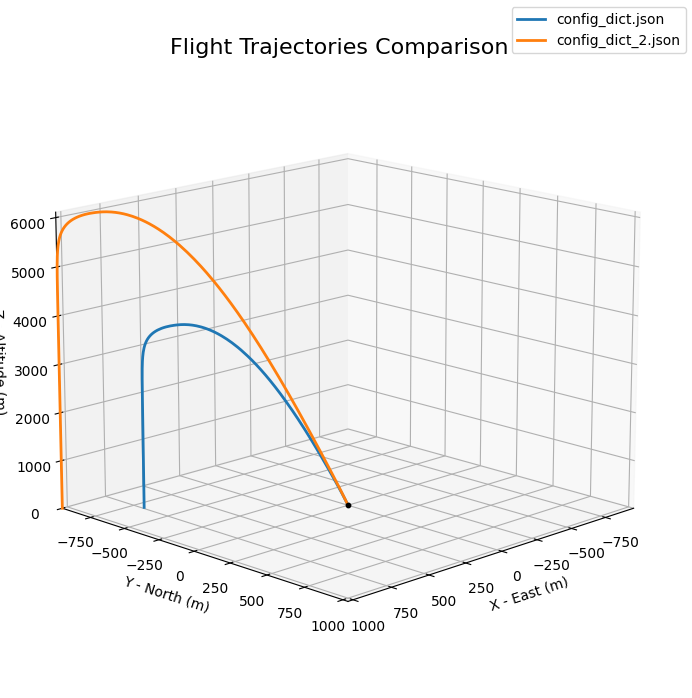

In [50]:
comparison = CompareFlights(flight_list)
comparison.trajectories_3d(legend=True)